In [1]:
# Imports
import pandas as pd
from shapely import geometry
import matplotlib.pyplot as plt
import geopandas
import shapely.wkt

In [2]:
# With Keywords
df = pd.read_csv ('data/results_WithKeywords.csv')

# Without Keywords
df2 = pd.read_csv ('data/results_NoKeywords.csv')

# Read Vertices
vert_df = pd.read_csv('data/vertices_20220621.csv')

# Read Polygon File
poly_df = pd.read_csv('data/polygon_20201027.csv')

# Launches
launch_df = pd.read_csv('data/launches_20201027.csv', parse_dates=['LAUNCH_DATE'])

# Read Spaceports
ports = pd.read_csv ('data/spaceports_20201027.csv')

# Read Basemap Shapefile
states = geopandas.read_file('data/bound_p.shx')

# ARTCC
artcc = pd.read_csv ('data/faa_artcc_polygons.csv')

In [3]:
df['LAUNCHES_REC_ID'].unique()

array([243, 248, 249, 251, 254, 257, 258, 259, 260, 261, 262, 263, 266,
       267, 270, 275, 276, 279, 282, 283, 284, 286, 287, 295, 296, 301,
       303, 304, 305, 306, 307, 308, 310, 312, 316, 319, 324, 325, 326,
       329, 330, 332, 339, 340, 341, 342, 345, 347, 349, 350, 351, 352,
       353, 354, 355, 358, 359, 362, 363, 365, 366, 369, 370, 371, 372,
       373, 375, 376, 377, 379, 382, 383, 384, 385, 386, 387, 388, 389,
       390, 391, 393, 394, 395, 399, 400, 402, 404, 407, 410, 413, 415,
       419, 420, 424, 428, 430, 431, 434, 435, 437, 438, 441, 442, 443,
       445, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 461, 463,
       466, 468, 470, 471, 474, 475, 476, 479, 487, 492, 494, 496, 497,
       499, 500, 501, 510, 511, 512, 514, 515, 516, 517])

In [4]:
df2['LAUNCHES_REC_ID'].unique()

array([140, 201, 234, 236, 243, 248, 249, 251, 254, 256, 257, 258, 259,
       260, 261, 262, 263, 266, 267, 268, 269, 270, 274, 275, 276, 277,
       278, 279, 282, 283, 284, 286, 287, 290, 295, 296, 298, 301, 303,
       304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
       317, 318, 319, 321, 323, 324, 325, 326, 327, 328, 329, 330, 332,
       333, 336, 337, 338, 339, 340, 341, 342, 345, 347, 348, 349, 350,
       351, 352, 353, 354, 355, 356, 358, 359, 360, 361, 362, 363, 365,
       366, 367, 369, 370, 371, 372, 373, 374, 375, 376, 377, 379, 380,
       381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
       394, 395, 396, 399, 400, 401, 402, 404, 406, 407, 408, 409, 410,
       412, 413, 414, 415, 416, 419, 420, 421, 422, 424, 425, 427, 428,
       429, 430, 431, 432, 433, 434, 435, 437, 438, 440, 441, 442, 443,
       445, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458,
       461, 463, 465, 466, 468, 470, 471, 472, 473, 474, 475, 47

In [5]:
# Creates WKT Polygons
def getPolygons(id_list):
    all_polys = {}

    for poly_id in id_list:
        tmp = vert_df[vert_df['POLYGON_ID'] == poly_id]

        long = tmp['LONGITUDE'].astype(str).values
        lat = tmp['LATITUDE'].astype(str).values

        pointList = list(zip(tmp['LONGITUDE'], tmp['LATITUDE']))

        if len(pointList) == 1:
            poly = geometry.Point([pointList[0][0], pointList[0][1]])
        elif len(pointList) == 2:
            poly = geometry.LineString([[p[0], p[1]] for p in pointList])
        else:
            poly = geometry.Polygon([[p[0], p[1]] for p in pointList])

        all_polys[poly_id] = poly
        
    return all_polys

# Gets Poylgon ID from NOTAM ID
def getIds(rec_ids):
    id_list = []
    rec_ids = list(map(int,rec_ids.iloc[0].strip('][').split(', ')))
    
    for row in rec_ids:
        for item in poly_df[poly_df['NOTAM_REC_ID'] == row]['POLYGON_ID'].values:
            id_list.append(item)
            
    return id_list

def plotLaunch(launch_id, with_keyword = True, with_artcc = False):
    if with_keyword:
        if launch_id in df['LAUNCHES_REC_ID'].unique():
            # Get IDs for Candidate NOTAMs
            id_list = getIds(df[df['LAUNCHES_REC_ID'] == launch_id]['DISCOVERED'])

            # Get Polygons for Candidate NOTAMs
            P = getPolygons(id_list)
        else:
            print('Error: No results for specified LAUNCHES_REC_ID.')
            return
    else:
        if launch_id in df2['LAUNCHES_REC_ID'].unique():
            # Get IDs for Candidate NOTAMs
            id_list = getIds(df2[df2['LAUNCHES_REC_ID'] == launch_id]['DISCOVERED'])

            # Get Polygons for Candidate NOTAMs
            P = getPolygons(id_list)
        else:
            print('Error: No results for specified LAUNCHES_REC_ID.')
            return
    
    # Plot Base Map
    states.plot(cmap='Pastel2', figsize=(30, 10))

    # Plot NOTAM Polygons
    for item in P.values():
        #if P:
         #   continue
        if item.geom_type != 'Polygon':
            plt.plot(*item.xy)
        else:
            x,y = item.exterior.xy
            plt.plot(x,y)

    # ARTCC
    if with_artcc:
        P2 = [shapely.wkt.loads(h) for h in artcc['boundary']]
    
        for item in P2:
            x,y = item.exterior.xy
            plt.plot(x,y, linestyle="dashdot")

    # Plot Spaceport Locations
    plt.plot(ports['LONGITUDE'], ports['LATITUDE'], marker="o", markeredgecolor="red", markerfacecolor="yellow", linestyle="None")

    port_id = launch_df[launch_df['LAUNCHES_REC_ID'] == launch_id]['SPACEPORT_REC_ID'].values
    
    # Set Zoom
    if port_id in [13]:
        plt.axis([-178, -149, 15, 38]) # 13
    elif port_id in [9]:
        plt.axis([-78, -70, 30, 42]) # 9 
    elif port_id in [2, 3, 8, 18, 20]:
        plt.axis([-85, -60, 24, 33]) # 2, 3, 8, 18, 20
    elif port_id in [6, 11, 23]:
        plt.axis([-125, -110, 30, 40]) # 23, 11, 6
    elif port_id in [14, 15]:
        plt.axis([-170, -140, 40, 75]) # 14, 15
    elif port_id in [24]:
        plt.axis([-111, -100, 28, 38]) # 24
    
    plt.ylabel('Lat.')
    plt.xlabel('Long.')
    plt.title('NOTAM Geometries')

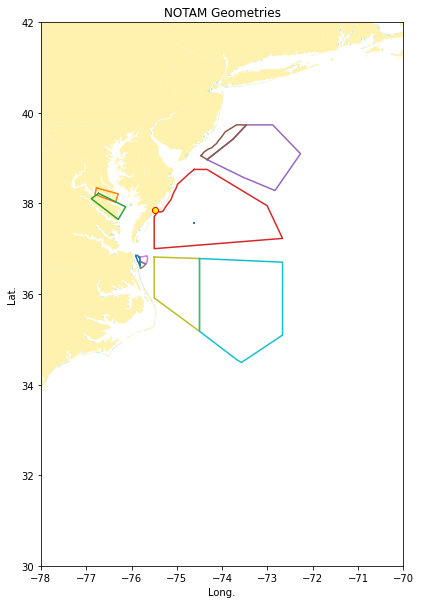

In [6]:
plotLaunch(launch_id = 390, with_keyword = False, with_artcc = False)